## 1. Import libraries.

Install libraries.

In [1]:
!conda install -c conda-forge lxml --yes
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes 
!conda install -c conda-forge wordcloud==1.4.1 --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.8.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - lxml


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    scikit-learn-0.20.1        |   py36h22eb022_0         5.7 MB
    certifi-2019.11.28         |           py36_0         149 KB  conda-forge
    liblapack-3.8.0            |      11_openblas          10 KB  conda-forge
    liblapacke-3.8.0           |      11_openblas          10 KB  conda-forge
    libopenblas-0.3.6          |       h5a2b251_2         7.7 MB
    numpy-1.17.3               |   py36h95a1406_0         5.2 MB  conda-forge
    scipy-1.4.1                |   py36h921218d_0        18.9 MB  conda-forge
    libc

Import libraries.

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

from wordcloud import WordCloud, STOPWORDS

## 1. Download and Explore Dataset

Download json file and load the data.

In [3]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset

In [4]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

Take *features* from the dataset.

In [5]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

## 2. Transform the data into a *pandas* dataframe.

Create an empty dataframe.

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


Loop through the data and fill the dataframe one row at a time.

In [7]:
for data in neighborhoods_data:
    borough = data['properties']['borough']
    neighborhood_name = data['properties']['name']        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Print the numbers of boroughs and neighborhoods.

In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]))

The dataframe has 5 boroughs and 306 neighborhoods.


## 3. Plot the geographical location of each neighborhood on the map.

Get the geographical location of the New York City.

In [9]:
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [10]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)
bronx_data = neighborhoods[neighborhoods['Borough'] == 'Bronx'].reset_index(drop=True)
staten_island_data = neighborhoods[neighborhoods['Borough'] == 'Staten Island'].reset_index(drop=True)

In [11]:
map_new_york = folium.Map(location=[latitude, longitude], zoom_start=11)

Define a function to add markers on the map.

In [12]:
def add_marker(m_latitude, m_longitude, m_neighborhood, m_color, m_fill_color, m_map):
    for lat, lng, label in zip(m_latitude, m_longitude, m_neighborhood):
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=4,
            popup=label,
            color=m_color,
            fill=True,
            fill_color=m_fill_color,
            fill_opacity=0.7,
            parse_html=False).add_to(m_map)

Add markers to the New York City map.

In [13]:
# add manhattan markers to map
add_marker(manhattan_data['Latitude'],
           manhattan_data['Longitude'],
           manhattan_data['Neighborhood'],
           'blue',
           '#3186cc',
           map_new_york)

In [14]:
# add brooklyn markers to map
add_marker(brooklyn_data['Latitude'],
           brooklyn_data['Longitude'],
           brooklyn_data['Neighborhood'],
           'red',
           '#cc3150',
           map_new_york)

In [15]:
# add queens markers to map
add_marker(queens_data['Latitude'],
           queens_data['Longitude'],
           queens_data['Neighborhood'],
           'green',
           '#31cc4b',
           map_new_york)

In [16]:
# add bronx markers to map
add_marker(bronx_data['Latitude'],
           bronx_data['Longitude'],
           bronx_data['Neighborhood'],
           'yellow',
           '#ccc431',
           map_new_york)

In [17]:
# add staten island markers to map
add_marker(staten_island_data['Latitude'],
           staten_island_data['Longitude'],
           staten_island_data['Neighborhood'],
           'purple',
           '#8431cc',
           map_new_york)

Show the neighborhood map.

In [18]:
map_new_york

## 4. Request venue data from Foursquare.

Define Foursquare Credentials and Version.

In [19]:
secrets = json.load(open('credential.json'))
CLIENT_ID = secrets['CLIENT_ID']
CLIENT_SECRET = secrets['CLIENT_SECRET']
VERSION = '20191201'

Limit of number of venues returned by Foursquare API

In [20]:
LIMIT = 100 

Define function to extract the category of the venue.

In [21]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Create a function to get the nearby venues of each neighborhood that are within 500 meter radius.

In [22]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Create a new dataframe called *manhattan_venues*, *brooklyn_venues*, *queens_venues*, *bronx_venues*, and *staten_island_venues*.

In [23]:
manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],
                                   latitudes=manhattan_data['Latitude'],
                                   longitudes=manhattan_data['Longitude']
                                  )

In [24]:
brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],
                                   latitudes=brooklyn_data['Latitude'],
                                   longitudes=brooklyn_data['Longitude']
                                  )

In [25]:
queens_venues = getNearbyVenues(names=queens_data['Neighborhood'],
                                   latitudes=queens_data['Latitude'],
                                   longitudes=queens_data['Longitude']
                                  )

In [26]:
bronx_venues = getNearbyVenues(names=bronx_data['Neighborhood'],
                                   latitudes=bronx_data['Latitude'],
                                   longitudes=bronx_data['Longitude']
                                  )

In [27]:
staten_island_venues = getNearbyVenues(names=staten_island_data['Neighborhood'],
                                   latitudes=staten_island_data['Latitude'],
                                   longitudes=staten_island_data['Longitude']
                                  )

Check the sizes of the resulting dataframe.

In [28]:
print('The size of manhattan dataframe is {}.'.format(manhattan_venues.shape))
print('The size of brooklyn dataframe is {}.'.format(brooklyn_venues.shape))
print('The size of queens dataframe is {}.'.format(queens_venues.shape))
print('The size of bronx dataframe is {}.'.format(bronx_venues.shape))
print('The size of staten island dataframe is {}.'.format(staten_island_venues.shape))

The size of manhattan dataframe is (3306, 7).
The size of brooklyn dataframe is (2816, 7).
The size of queens dataframe is (2087, 7).
The size of bronx dataframe is (1206, 7).
The size of staten island dataframe is (830, 7).


Print how many unique categories can be curated from all the returned venues.

In [29]:
print('There are {} uniques categories in manhattan.'.format(len(manhattan_venues['Venue Category'].unique())))
print('There are {} uniques categories in brooklyn.'.format(len(brooklyn_venues['Venue Category'].unique())))
print('There are {} uniques categories in queens.'.format(len(queens_venues['Venue Category'].unique())))
print('There are {} uniques categories in bronx.'.format(len(bronx_venues['Venue Category'].unique())))
print('There are {} uniques categories in staten island.'.format(len(staten_island_venues['Venue Category'].unique())))

There are 338 uniques categories in manhattan.
There are 291 uniques categories in brooklyn.
There are 266 uniques categories in queens.
There are 170 uniques categories in bronx.
There are 182 uniques categories in staten island.


## 5. List the top venue category in each borough.

Define a function to filter the top venue category.

In [30]:
def get_top_category(venue_name):
    df1=venue_name.groupby('Venue Category').size().reset_index(name="Count")
    df2 = df1.sort_values('Count', ascending=False)
    df2 = df2.set_index('Venue Category')
    df2[r'Percentage (%)']=df2['Count']/venue_name.shape[0]*100
    df3=df2.head(10)
    return(df3)

Obtain the top venues in each borough.

In [31]:
man_top_venues=get_top_category(manhattan_venues)
bln_top_venues=get_top_category(brooklyn_venues)
que_top_venues=get_top_category(queens_venues)
brx_top_venues=get_top_category(bronx_venues)
sta_top_venues=get_top_category(staten_island_venues)

In [32]:
man_top_venues

,Count,Percentage (%)
Venue Category,,
Coffee Shop,132,3.992740
Italian Restaurant,130,3.932244
American Restaurant,82,2.480339
Café,78,2.359347
Bakery,75,2.268603
Pizza Place,74,2.238355
Park,67,2.026618
Cocktail Bar,65,1.966122
Hotel,60,1.814882


In [33]:
bln_top_venues

,Count,Percentage (%)
Venue Category,,
Pizza Place,124,4.403409
Coffee Shop,89,3.160511
Bar,83,2.947443
Deli / Bodega,67,2.379261
Italian Restaurant,65,2.308239
Bakery,62,2.201705
Pharmacy,55,1.953125
Grocery Store,55,1.953125
Chinese Restaurant,53,1.882102


In [34]:
que_top_venues

,Count,Percentage (%)
Venue Category,,
Pizza Place,88,4.216579
Deli / Bodega,74,3.545759
Chinese Restaurant,58,2.779109
Donut Shop,55,2.635362
Bakery,53,2.539530
Bank,49,2.347868
Pharmacy,47,2.252036
Bar,43,2.060374
Grocery Store,41,1.964542


In [35]:
brx_top_venues

,Count,Percentage (%)
Venue Category,,
Pizza Place,102,8.457711
Deli / Bodega,53,4.394693
Donut Shop,45,3.731343
Pharmacy,41,3.399668
Sandwich Place,39,3.233831
Supermarket,39,3.233831
Italian Restaurant,38,3.150912
Bus Station,35,2.902156
Bank,35,2.902156


In [36]:
sta_top_venues

,Count,Percentage (%)
Venue Category,,
Bus Stop,53,6.385542
Pizza Place,50,6.024096
Italian Restaurant,42,5.060241
Deli / Bodega,41,4.939759
Bagel Shop,23,2.771084
Pharmacy,21,2.530120
Coffee Shop,21,2.530120
Sandwich Place,20,2.409639
Bank,19,2.289157


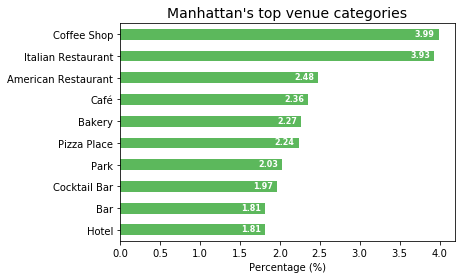

In [37]:
ax = (man_top_venues[r'Percentage (%)'].sort_values(ascending=True)).plot(kind='barh', color = '#5cb85c')

ax.set_title('Manhattan\'s top venue categories', fontsize=14)
ax.set_xlabel(r'Percentage (%)')
ax.set_ylabel('')

for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.x1)        
    ax.annotate(val, (b.x1-0.3, b.y1-0.32), fontsize = 8, weight='bold', color='white')

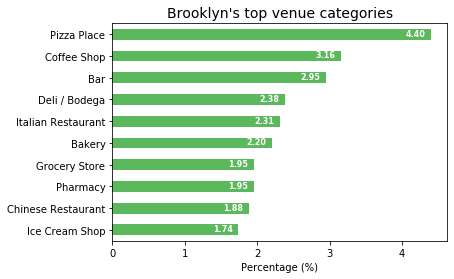

In [38]:
ax = (bln_top_venues[r'Percentage (%)'].sort_values(ascending=True)).plot(kind='barh', color = '#5cb85c')

ax.set_title('Brooklyn\'s top venue categories', fontsize=14)
ax.set_xlabel(r'Percentage (%)')
ax.set_ylabel('')

for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.x1)        
    ax.annotate(val, (b.x1-0.35, b.y1-0.32), fontsize = 8, weight='bold', color='white')

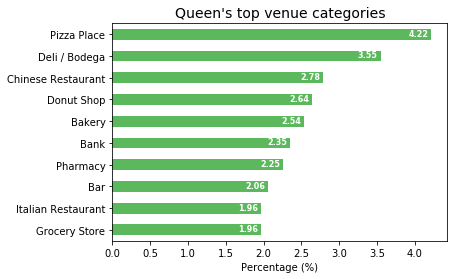

In [39]:
ax = (que_top_venues[r'Percentage (%)'].sort_values(ascending=True)).plot(kind='barh', color = '#5cb85c')

ax.set_title('Queen\'s top venue categories', fontsize=14)
ax.set_xlabel(r'Percentage (%)')
ax.set_ylabel('')

for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.x1)        
    ax.annotate(val, (b.x1-0.3, b.y1-0.32), fontsize = 8, weight='bold', color='white')

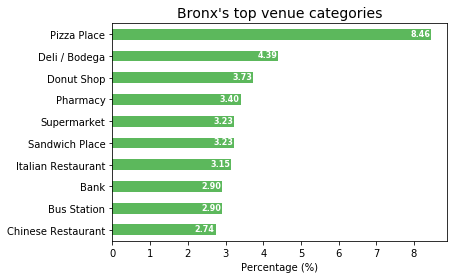

In [40]:
ax = (brx_top_venues[r'Percentage (%)'].sort_values(ascending=True)).plot(kind='barh', color = '#5cb85c')

ax.set_title('Bronx\'s top venue categories', fontsize=14)
ax.set_xlabel(r'Percentage (%)')
ax.set_ylabel('')

for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.x1)        
    ax.annotate(val, (b.x1-0.55, b.y1-0.32), fontsize = 8, weight='bold', color='white')

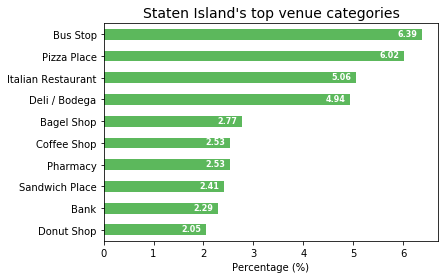

In [41]:
ax = (sta_top_venues[r'Percentage (%)'].sort_values(ascending=True)).plot(kind='barh', color = '#5cb85c')

ax.set_title('Staten Island\'s top venue categories', fontsize=14)
ax.set_xlabel(r'Percentage (%)')
ax.set_ylabel('')

for p in ax.patches:
    b = p.get_bbox()
    val = "{:.2f}".format(b.x1)        
    ax.annotate(val, (b.x1-0.5, b.y1-0.32), fontsize = 8, weight='bold', color='white')

## 6. Filter the unique venue category in each borough.

Define a function to obtain the venue category of each borough.

In [42]:
def get_category(venue_name):
    df1=venue_name.groupby('Venue Category').size().reset_index(name="Count")
    df2 = df1.sort_values('Count', ascending=False)
    df2 = df2.set_index('Venue Category')
    return(df2)

Get the venue category of each borough.

In [43]:
man_venues=get_category(manhattan_venues)
bln_venues=get_category(brooklyn_venues)
que_venues=get_category(queens_venues)
brx_venues=get_category(bronx_venues)
sta_venues=get_category(staten_island_venues)

Extract the venue categories in other boroughs.

In [44]:
df1 = pd.concat([bln_venues, que_venues, brx_venues, sta_venues])
df2 = pd.concat([man_venues, que_venues, brx_venues, sta_venues])
df3 = pd.concat([man_venues, bln_venues, brx_venues, sta_venues])
df4 = pd.concat([man_venues, bln_venues, que_venues, sta_venues])
df5 = pd.concat([man_venues, bln_venues, que_venues, brx_venues])

In [45]:
temp1=list(df1.index)
temp2=list(df2.index)
temp3=list(df3.index)
temp4=list(df4.index)
temp5=list(df5.index)

In [46]:
man_venues.reset_index(inplace=True)
bln_venues.reset_index(inplace=True)
que_venues.reset_index(inplace=True)
brx_venues.reset_index(inplace=True)
sta_venues.reset_index(inplace=True)

Obtain the unique venue category in each borough.

In [47]:
man_venues.rename(columns = {'Venue Category':'Category'}, inplace = True)
bln_venues.rename(columns = {'Venue Category':'Category'}, inplace = True)
que_venues.rename(columns = {'Venue Category':'Category'}, inplace = True)
brx_venues.rename(columns = {'Venue Category':'Category'}, inplace = True)
sta_venues.rename(columns = {'Venue Category':'Category'}, inplace = True)

In [48]:
man_unique=man_venues[~man_venues.Category.isin(temp1)]
bln_unique=bln_venues[~bln_venues.Category.isin(temp2)]
que_unique=que_venues[~que_venues.Category.isin(temp3)]
brx_unique=brx_venues[~brx_venues.Category.isin(temp4)]
sta_unique=sta_venues[~sta_venues.Category.isin(temp5)]

In [49]:
man_tmp = man_unique.reset_index(drop=True)
bln_tmp = bln_unique.reset_index(drop=True)
que_tmp = que_unique.reset_index(drop=True)
brx_tmp = brx_unique.reset_index(drop=True)
sta_tmp = sta_unique.reset_index(drop=True)

Display the unique venue categories in each borough.

In [50]:
man_tmp

,Category,Count
0,Cupcake Shop,12
1,Exhibit,8
2,Australian Restaurant,5
3,Design Studio,3
4,Memorial Site,3
5,Street Art,3
6,Japanese Curry Restaurant,3
7,Pet Café,3
8,Music School,3
9,Public Art,2


In [51]:
bln_tmp

,Category,Count
0,Piercing Parlor,2
1,Vape Store,2
2,Ski Area,1
3,Stadium,1
4,Stationery Store,1
5,Varenyky restaurant,1
6,Cha Chaan Teng,1
7,Field,1
8,Factory,1
9,Event Service,1


In [52]:
que_tmp

,Category,Count
0,Colombian Restaurant,3
1,Train,2
2,Shop & Service,2
3,Automotive Shop,2
4,State / Provincial Park,1
5,College Basketball Court,1
6,Souvlaki Shop,1
7,Bath House,1
8,Beach Bar,1
9,Border Crossing,1


In [53]:
brx_tmp

,Category,Count
0,Track,2
1,Waste Facility,2
2,River,1
3,Shopping Plaza,1
4,Film Studio,1
5,Medical Supply Store,1


In [54]:
sta_tmp

,Category,Count
0,Sri Lankan Restaurant,1
1,Campground,1
2,Toll Plaza,1
3,Theme Park,1
4,Tex-Mex Restaurant,1
5,Tanning Salon,1
6,Recording Studio,1
7,Insurance Office,1
8,Professional & Other Places,1
9,Outlet Mall,1


Replace space if there is any.

In [55]:
man = man_tmp.replace(' ', '', regex=True)
bln = bln_tmp.replace(' ', '', regex=True)
que = que_tmp.replace(' ', '', regex=True)
brx = brx_tmp.replace(' ', '', regex=True)
sta = sta_tmp.replace(' ', '', regex=True)

## 7. Visualize the unique venue category in each borough.

In [56]:
man_vis = man.set_index('Category')
bln_vis = bln.set_index('Category')
que_vis = que.set_index('Category')
brx_vis = brx.set_index('Category')
sta_vis = sta.set_index('Category')

Define a function to visualize the unique venue category in each borough.

In [63]:
def vis_unique_venue(dataset):
    word_string = ''
    for category in dataset.index.values:
        repeat_num_times = int(dataset.loc[category, 'Count'])
        word_string = word_string + ((category + ' ') * repeat_num_times)
        
    wordcloud = WordCloud(background_color='white').generate(word_string)
    # display the cloud
    fig = plt.figure()
    fig.set_figwidth(10)
    fig.set_figheight(14)

    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')

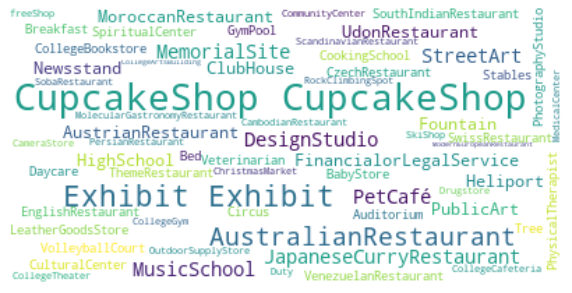

In [64]:
vis_unique_venue(man_vis)

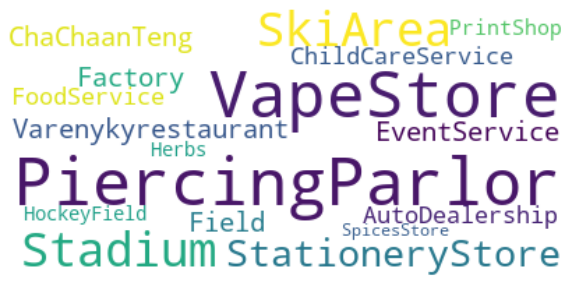

In [65]:
vis_unique_venue(bln_vis)

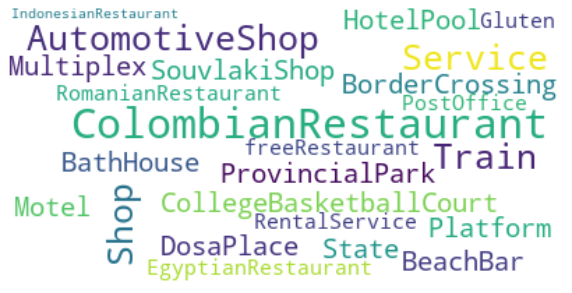

In [66]:
vis_unique_venue(que_vis)

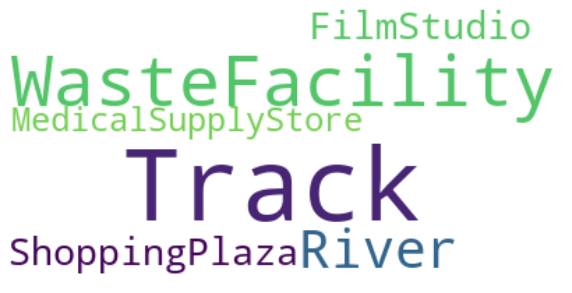

In [67]:
vis_unique_venue(brx_vis)

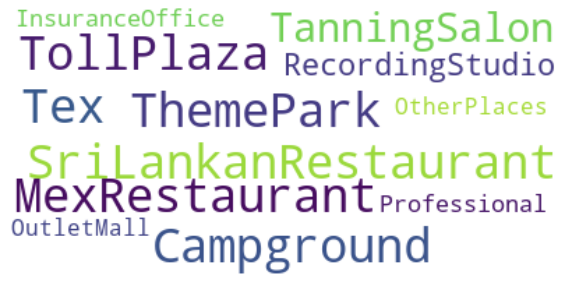

In [68]:
vis_unique_venue(sta_vis)